In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from tqdm import tqdm, trange

from toydown import ToyDown

In [2]:
filename = "Blocks/dallas_county_blocks10.shp"
toy = ToyDown(filename, "GEOID10", "TOTPOP10")

num_runs = 1000
eps_budget = 1   
save_fp = "single_attr_runs.csv"
epsilon_splits = {"equal": [0.2,0.2,0.2,0.2,0.2], 
                  "top_heavy": [1/2, 1/4, 1/12, 1/12, 1/12],
                  "mid_heavy": [1/12, 1/6, 1/2, 1/6, 1/12], 
                  "bottom_heavy": [1/12, 1/12, 1/12, 1/4, 1/2],
                  "bg_heavy": [1/12, 1/6, 1/6, 1/2, 1/12]}

toy.set_noising_params(eps_budget, epsilon_splits["equal"])

In [3]:
# do the runs
runs = []
property_name = "noised_pop"

for i in range(num_runs):
    if i % 100 == 0:
        print(i)
    toy.noise_and_adjust()
    
    props = toy.get_leaf_properties(property_name)
    props = props.rename(columns={property_name: "Run_{}".format(i)})
    runs.append(props)

# combine into one dataframe
runs_df = reduce(lambda df1,df2: pd.merge(df1,df2,on='GEOID'), runs)
runs_df.to_csv(save_fp, index=False)

0
100
200
300
400
500
600
700
800
900


In [4]:
block_recom = np.load("100_recom_block_parts_comp.npy", allow_pickle=True)[0]["dicts"]
runs_df = pd.read_csv(save_fp)

In [13]:
def district_frag_scores(model, districts):
    """
    """
    num_districts = len(districts)
    frag_scores = np.zeros(num_districts)
    print("Computing frag scores")
    
    for i in tqdm(range(num_districts)):
        frag_scores[i] = model.assign_district_tree_variance(districts[i], 
                                                             eps=1, 
                                                             eps_splits=[np.sqrt(2)]*5,
                                                             sensitivity=1)
    return frag_scores

def analytical_district_variances(model, districts, num_attributes=1):
    """
    """
    vrs = {}
    num_districts = len(districts)
    print("Computing analytical variances")
    
    for split in ["equal"]:
        vs = np.array([model.assign_district_tree_variance(dist, 
                                                           eps=eps_budget, 
                                                           eps_splits=epsilon_splits[split]) for dist in districts])*num_attributes
        vrs[split] = vs
    return vrs

def toydown_single_attr_empirical_vars(model, districts, runs_df, num_runs):
    """
    """
    num_districts = len(districts)
    empirical_vars = np.zeros(num_districts)
    run_cols = ["Run_{}".format(i) for i in range(num_runs)]
    print("Computing Empirical Variances")
    
    for j in tqdm(range(num_districts)):
        empirical_vars[j] = np.var(runs_df[runs_df["GEOID"].astype(str).apply(lambda i: bool(districts[j][i]))][run_cols].sum())
    return empirical_vars

In [14]:
for district_type, ds in [("block_recom", block_recom)]:
    print("Starting {} calculations".format(district_type), flush=True)
    frag_scores = district_frag_scores(toy, ds)
    analytical_vars = analytical_district_variances(toy, ds)
    empirical_vars = toydown_single_attr_empirical_vars(toy, ds, runs_df, num_runs)

Starting block_recom calculations


  0%|          | 0/398 [00:00<?, ?it/s]

Computing Empirical Variances


100%|██████████| 398/398 [01:15<00:00,  5.31it/s]


In [15]:
len(frag_scores)
len(analytical_vars["equal"])
len(empirical_vars)

398

In [16]:
import seaborn as sns
data = pd.DataFrame({"frag_scores": frag_scores, 
                     "analytical_vars": analytical_vars["equal"], 
                     "empirical_vars": empirical_vars
                    })

<ipython-input-22-529deef468f3>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

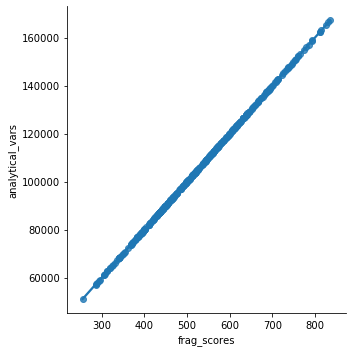

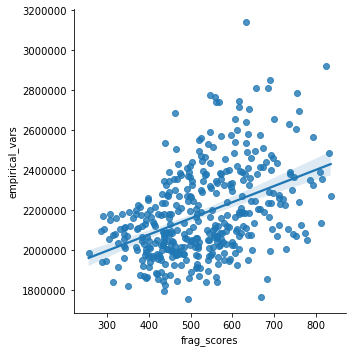

In [22]:
fig = plt.figure()
sns.lmplot(data=data, x="frag_scores", y="analytical_vars")
sns.lmplot(data=data, x="frag_scores", y="empirical_vars")
fig.show()

In [12]:
run_cols = ["Run_{}".format(i) for i in range(num_runs)]

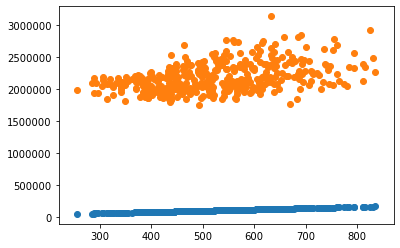

In [25]:
plt.scatter(data["frag_scores"], data["analytical_vars"])
plt.scatter(data["frag_scores"], data["empirical_vars"])